# Machine Learning Basics I: Regression Models
### Author: Harris Bunker
### Updated: July 24, 2019

Regression is a task: not strictly an algorithm. In it, a model is constructed to predict a (usually continuous) value. This demo will explain the essential regressional algorithms and models and will offer the base level mathematical explenation necessary to understand them. 

This demo will use pandas and numpy which are essential to machine learning in Python. They are the daily drivers of productivity and I will explain things as we go. Please refer to the statistics notebooks (forthcoming) for background on mean, variance, distributions, etc.

## Part 0: Data Import and standardizing
This part is essential to any project of course. I will be using the canonical wine dataset where we will be trying to predict wine quality. Throughout this demo, I will try to have all the code run in functions except when it gets in the way of readability. Having local information is almost always a good programming practice.

We will split the data into a train set and a test set. The train set will be used to construct the models and the test set will be used to see how well are model performed.

In a real ML project, this data pre-processing and cleaning takes up the vast majority of the development time.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #used for this Seaborn -> Scipy warning that I can't fix

def load_data(partition_size = .2):
    '''
    Input: Partition size-percentage of data to use for test data set
    Output: Returns X_train, X_test, Y_train, Y_test for wine data set
    '''
    #this data happens to be separated by a semi-colon which is not uncommon
    df = pd.read_csv("./wine_data/winequality-red.csv", sep = ';')
    #df is a Pandas dataframe. Pandas dataframe ase similar to R dataframes but are made up of numpy arrays and not vectors.
    #print(df) #often helpful to print your data frame. We will be predicting the last column so we need to isolate that later
    
    print(df.shape) 
    #dimensions of the data frame. 
    #It looks to be 11 features (X variables) and 1 label (Y variable we want to predict) and 1599 samples/observations
    df_Y = df.iloc[:,-1] #slicing with iloc[] rather than loc[] which uses names
    df_X = df.iloc[:,0:-1] #everything except last column
    
    #print(df_Y)
    X_train, X_test, y_train, y_test = train_test_split(
                                    df_X, df_Y, test_size = partition_size, random_state=328) #random state set for consistency
    #test size is usually between 10 and 33 percent
    y_train = np.asarray(y_train) #easier to index arrays than Pandas series/data frames
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test
    
def standardize(X_train, X_test):
    '''
    Input: two arrays
    Output: standarized arrays that are in (-1,1)
    '''
    mean = X_train.mean(axis = 0) #have to take mean on training data
    #axis = 0 is the dimension to consider but this is only relevant for multi-dimensional arrays
    std = X_train.std(axis = 0)
    
    #standarize with the mean and standard deviation of the train data
    #this allows "coefficients" to easily be interpreted as they will be on the same scale
    X_train_std = (X_train - mean)/std 
    X_test_std = (X_test - mean)/std    
    return X_train_std, X_test_std

X_train, X_test, y_train, y_test = load_data()

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)
    #arrays look like (M,) in one 1D representation

X_train_std, X_test_std = standardize(X_train, X_test)

(1599, 12)
(1279, 11)
(320, 11)
(1279,)
(320,)


### Helper Functions

In [2]:
None

## Statistics

In [3]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

def get_stats(predict, target):
    '''
    Input: predicted array (m,k) and target array (m,1)
    Output: dictionary with three correlation statistics and RMSE to evaluate model
    '''
    #RMSE is basically the square root of the average L2 distance the prediction is off from the truth
    rmse = mean_squared_error(target, predict)
    #pearson r is the standard R from statistics: cov(X,Y)/(std(X)*std(Y))
    pearson = pearsonr(predict, target)[0]
    #Spearman's r is Pearson's R but uses the ranks of the predictions and the target. It's in some sense less parametric 
    spearman = spearmanr(predict, target)[0]
    #Kendall Tau B's considers how much the predictions and the targets agree on relative rank. Ties are considered in this version
    kt_b = kendalltau(predict, target)[0]
    
    return {'RMSE': round(rmse,3),
            'Pearson': round(pearson,3), 
            'Spearman': round(spearman,3), 
            'Kendall-Tau-B': round(kt_b,3)} #rounded to three decimals

## Plotting
We will plot our regression model versus the truth to see where it differs. I will be using Seaborn for this.

In [4]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

def plot(predict, target):
    '''
    Returns a plot
    '''
    plt.clf()
    df = pd.DataFrame({'predicted quality':predict, 'actual quality':target})
    #print(predict.shape,target.shape)
    ax = sns.regplot(x = 'predicted quality', y = 'actual quality', data = df, color = 'red')
    return ax

## Part 1A: Linear Regression

Linear regression is the most basic machine learning model. In it, we set the response variable (the label) $y = \vec{\beta}\vec{X}$ where $\vec{\beta}$ is the $k \times 1$ vector of coefficients for each of the $k-1$ variables (we need an intercept term $\beta_0$.) Several assumptions are made in linear regression: the chief among them being the homoskedacity (constant variance) and zero conditional mean assumption which means that there is no explicit endogenity in the model. Linear regression is a good baseline model for regression problems, as under the Gauss Markov assumptions (not realistic), the $\beta$ coefficients are the Best Linear Unbiased Estimator (BLUE). The explicit solution for the linear estimators comes from a simple optimization problem on $y = \beta x$ and follow the form:

$ \vec{\beta} = (X^TX)^{-1}X^Ty$ where $T$ denotes the transpose of the input $n x k$ input matrix. Each row of $X$ represents a single sample and each column is a feature/label. Please note that some literature uses $X'$ to denote X transpose.

{'RMSE': 0.444, 'Pearson': 0.593, 'Spearman': 0.599, 'Kendall-Tau-B': 0.473}


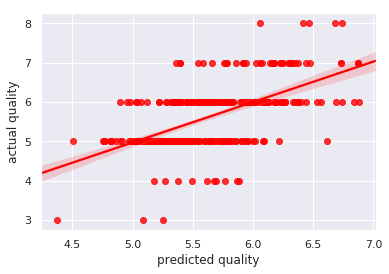

In [5]:
from sklearn.linear_model import LinearRegression

def LinearModel(X_train, X_test, y_train, y_test):
    '''
    Input: the partitioned data
    Output: the statistics associated with the linear model
    Also plots the predicted values with the actual values
    '''
    reg = LinearRegression().fit(X_train_std, y_train)
    #print(reg.coef_) # used to see how feature importance. Larger in absolute value -> more impact on the predicted value
    predicts = reg.predict(X_test)
    #predicts = np.array(predicts).round() #discretize predictions
    #this step is unecessary in most regression problems but it may make the results easier to understand
    stats = get_stats(predicts, y_test)
    plot(predicts, y_test)
    print(stats)
    return stats

lm_stats = LinearModel(X_train_std, X_test_std, y_train, y_test)

## Part 1B: Poisson Regression 
### with xgboost

Poisson regression has the same exact form as the linear case:
$y = \vec{\beta} \vec{x}$ but $y$ is $\ln(E(W|\vec{X}))$ and $E(W|\vec{X}) = e^{\beta^T\vec{X}} := \lambda$ where $\lambda$ is the mean of the response variable $W$. In short, we must assume that the data in $\mathbb{N}$ takes on a Poisson variable with mean $\lambda$. Poisson regression works best for count data (i.e. 1,2,3...).

Xgboost is a decision tree algorithm that in this case basically imposes the Poisson assumption on the response variable. Again, the key takeaway is the Poisson distribution on the response variable.

Likewise, an example by assuming another distribution (Gamma) is shown.

In [6]:
import xgboost as xgb
dmat_train = xgb.DMatrix(data = X_train_std, #have to use this format for Xgboost
                        label = y_train)
dmat_test = xgb.DMatrix(data  = X_test_std,
                        label = y_test)

bst = xgb.train(
        params={"objective": "count:poisson"}, #can use other objective functions here: see 
        #https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
        dtrain = dmat_train,
        num_boost_round=1000,
        early_stopping_rounds=100,
        evals=[(dmat_train, "train")],
        verbose_eval=False)

bst2 = xgb.train(
        params={"objective": "reg:gamma"}, #can use other objective functions here: see 
        #https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
        dtrain = dmat_train,
        num_boost_round=1000,
        early_stopping_rounds=100,
        evals=[(dmat_train, "train")],
        verbose_eval=False)

predicts = bst.predict(dmat_test)
predicts = predicts.round()
print(get_stats(predicts, y_test))

predicts_gamma = bst2.predict(dmat_test)
predicts_gamma = predicts_gamma.round()
get_stats(predicts_gamma,y_test)

{'RMSE': 0.488, 'Pearson': 0.594, 'Spearman': 0.614, 'Kendall-Tau-B': 0.574}


{'RMSE': 0.519, 'Pearson': 0.564, 'Spearman': 0.553, 'Kendall-Tau-B': 0.514}

## Part 2: k-Nearest Neighbors
k-Nearest Neighbors is a nonparametric method of both regression and classification. In it, a value or label is predicted based on the samples that are most similar in their features. Similarity is based on various distance metrics but Manhattan (L1) and Euclidean (L2) are the most common. This demo will include multiple metrics. Metrics here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

This method is very fast and works well for unstructured data you don't have a good model for. It makes a good baseline model but rarely will it be the best for your data.

metric: L1  k:: 1 {'RMSE': 0.641, 'Pearson': 0.52, 'Spearman': 0.523, 'Kendall-Tau-B': 0.482}
metric: L2  k:: 1 {'RMSE': 0.6, 'Pearson': 0.558, 'Spearman': 0.55, 'Kendall-Tau-B': 0.508}
....
metric: L1  k:: 3 {'RMSE': 0.538, 'Pearson': 0.504, 'Spearman': 0.516, 'Kendall-Tau-B': 0.441}
metric: L2  k:: 3 {'RMSE': 0.524, 'Pearson': 0.516, 'Spearman': 0.506, 'Kendall-Tau-B': 0.43}
....
metric: L1  k:: 5 {'RMSE': 0.513, 'Pearson': 0.516, 'Spearman': 0.535, 'Kendall-Tau-B': 0.439}
metric: L2  k:: 5 {'RMSE': 0.498, 'Pearson': 0.533, 'Spearman': 0.537, 'Kendall-Tau-B': 0.446}
....
metric: L1  k:: 10 {'RMSE': 0.491, 'Pearson': 0.536, 'Spearman': 0.536, 'Kendall-Tau-B': 0.435}
metric: L2  k:: 10 {'RMSE': 0.508, 'Pearson': 0.514, 'Spearman': 0.529, 'Kendall-Tau-B': 0.425}
....
metric: L1  k:: 15 {'RMSE': 0.493, 'Pearson': 0.533, 'Spearman': 0.543, 'Kendall-Tau-B': 0.435}
metric: L2  k:: 15 {'RMSE': 0.492, 'Pearson': 0.534, 'Spearman': 0.557, 'Kendall-Tau-B': 0.448}
....
metric: L1  k:: 20 {'RMSE'

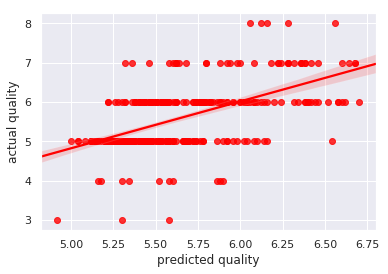

In [7]:
from sklearn.neighbors import KNeighborsRegressor
#metrics_list = sorted(sklearn.neighbors.VALID_METRICS['brute']) #list of available metrics
def KNNModel(X_train, X_test, y_train, y_test, k, metric = "L2"):
    #knn_model = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute', metric='mahalanobis', 
    #                           metric_params={'V': np.cov(X_train).fit(X_train, y_train)
    if metric == "L2":
        knn_model = KNeighborsRegressor(n_neighbors = k, algorithm = 'auto', p = 2).fit(X_train, y_train)
    if metric == "L1":
        knn_model = KNeighborsRegressor(n_neighbors = k, algorithm = 'auto', p = 1).fit(X_train, y_train)
    predicts = knn_model.predict(X_test)
    #predicts = np.array(predicts).round() #make integer
    stats = get_stats(predicts, y_test)
    plot(predicts, y_test)
    return stats

for k in [1,3,5,10,15,20,25,30,40,50]: #a primitive example of testing multiple k and multiple metrics
    for metric in ["L1","L2"]:
        print("metric:",metric, " k::", k, KNNModel(X_train_std, X_test_std, y_train, y_test, k, metric))
    print("....")

In [8]:
import sklearn

sorted(sklearn.neighbors.VALID_METRICS['brute'])

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'jaccard',
 'kulsinski',
 'l1',
 'l2',
 'mahalanobis',
 'manhattan',
 'matching',
 'minkowski',
 'precomputed',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'wminkowski',
 'yule']

## Part 3: Support Vector Machines

An older method, SVMs are still used in some applications today especially with appropiate kernel selection.

/home/harris/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'RMSE': 0.443, 'Pearson': 0.595, 'Spearman': 0.599, 'Kendall-Tau-B': 0.473}


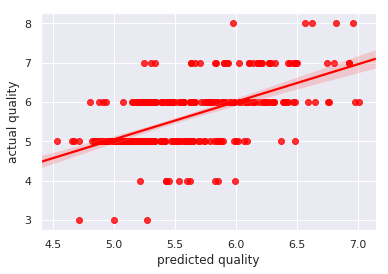

In [9]:
import sklearn.svm as svm
regr = svm.LinearSVR(random_state = 1, tol=1e-7, max_iter = 20000, C = 1).fit(X_train_std, y_train) #model converges at 5000 <= 10000 iterations

predicts = regr.predict(X_test_std)
stats = get_stats(predicts, y_test)
print(stats)
plot(predicts, y_test)

_nu-SVM_ allows one to have the hyperparameter $\nu \in [0,1.0]$ which is used in the penalty function for maximizing the margin. The hyperparameter $C \in \mathbb{R}^+$ is also allowed.

{'RMSE': 0.448, 'Pearson': 0.588, 'Spearman': 0.601, 'Kendall-Tau-B': 0.478}


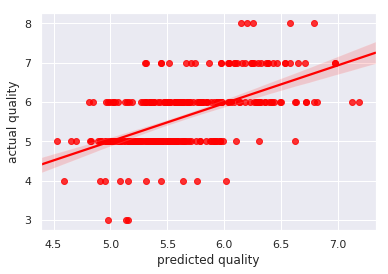

In [10]:
from sklearn.svm import NuSVR

clf = NuSVR(gamma='scale', C=2.0, nu=0.075).fit(X_train_std, y_train)
predicts = clf.predict(X_test_std)
stats = get_stats(predicts, y_test)
print(stats)
plot(predicts, y_test)

## Part 4: Regularized regression and advanced methods

In [11]:
from sklearn import linear_model

### 4.1 Ridge regression

minimizes $L(\vec X, \vec \beta) = ||\vec{X}\vec{\beta} - \vec{y}||^2_2 + \alpha ||\vec{\beta}||^2_2$ with respect to the $\beta$ coefficients where $\alpha$ is the "shrinkage" or penalty term in $\mathbb{R}^+$.

{'RMSE': 0.441, 'Pearson': 0.597, 'Spearman': 0.604, 'Kendall-Tau-B': 0.478}


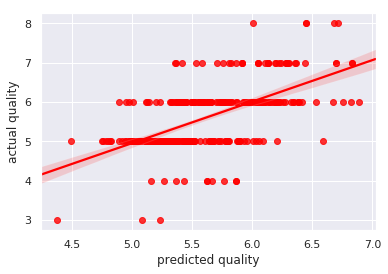

In [12]:
reg = linear_model.Ridge(alpha=.9)
reg.fit(X_train, y_train) #note the unstandarized input
predicts = reg.predict(X_test) #not standarized
stats = get_stats(predicts, y_test)
print(stats)
plot(predicts, y_test)

### 4.2 LASSO

As opposed to Ridge regression, LASSO tries to make sparse models by minimizing the amount of features used in the regression. As such, it can be used for feature importance and related applications. Instead of the $L_2$ regularization term utilized in Ridge, we instead utilize a $L_1$ regularization term. A potential mathematical justification for utilizing these $L_1$ and $L_2$ terms come from the differentiability of the loss function near the origin and a Taylor expansion of the loss function. We do not need higher order terms is the the short answer.

{'RMSE': 0.439, 'Pearson': 0.601, 'Spearman': 0.605, 'Kendall-Tau-B': 0.479}


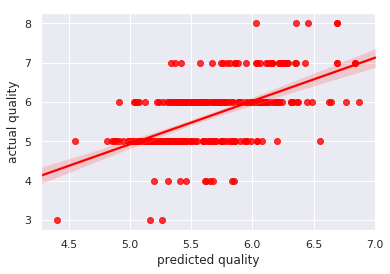

In [13]:
reg = linear_model.Lasso(alpha=0.01)
reg.fit(X_train_std, y_train)
y_pred = reg.predict(X_test_std)
print(get_stats(y_pred, y_test))
plot(y_pred, y_test)

### 4.3 Elastic-Net 
Allows for a mix of $L_1$ and $L_2$ regularization--making it a viable mix of LASSO and Ridge. For this short example, I preform a basic grid-search Cross Validation to select the right parameter alpha using several $\lambda$ possibilities which is the correction factor on the $L_1$ regularization term. To be curt, this method should be used when you feel there is strong correlation in the features and you want strinkage of the coefficients. An $\alpha$ term of $0$ corresponds to the Ridge estimator and an $\alpha = 1$ reduces to the LASSO estimator. As a technical note, in the sklearn package, we _cannot_ use a $L_1$ ratio or $\lambda$ value of $0.$ in Cross Validation so I chose $0.0001$. 

I'd recommend perusing this thread: https://stats.stackexchange.com/questions/93181/ridge-lasso-and-elastic-net and reading part of Hastie's _The Elements of Statistical Learning_ book which discusses these more advanced methods.

In [25]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(get_stats(y_pred,y_test))

{'RMSE': 0.66, 'Pearson': 0.194, 'Spearman': 0.26, 'Kendall-Tau-B': 0.206}


{'RMSE': 0.443, 'Pearson': 0.596, 'Spearman': 0.6, 'Kendall-Tau-B': 0.474}


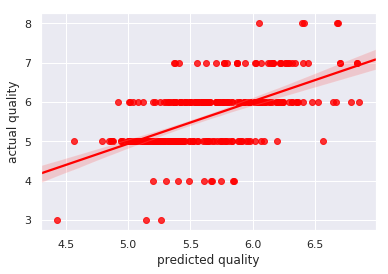

In [31]:
from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(cv = 4, random_state=1, l1_ratio = [0.0001, .05, .1, .5, .7, .9, .95, .99, 1], max_iter = 10000)
regr.fit(X_train_std, y_train)
y_pred = regr.predict(X_test_std)
stats = get_stats(y_pred, y_test)
print(stats)
plot(y_pred, y_test)

In [30]:
regr.alpha_ #the alpha generated for the ElasticNet we get from Cross Validation

0.03265736375892218

## Part 5: Random Forest Regressor

# Part 6: Model Comparision

In [ ]:
#have RMSE, model time and time to complte and maybe memory size of model